---
## Cell 1: Mount Google Drive & Import Libraries

In this section, we import the necessary Python libraries for data manipulation (`pandas`, `numpy`), visualization (`seaborn`, `matplotlib`), and machine learning (`sklearn`).

**Key Libraries:**
* `LinearSVC`: The primary Support Vector Machine model (optimized for large datasets).
* `CalibratedClassifierCV`: Wraps the SVM to provide probability estimates (required for ROC-AUC).
* `GridSearchCV`: For hyperparameter tuning.

In [1]:
# # # Mount Google Drive
# from google.colab import drive
# drive.mount('/content/drive')

# Core Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

# Scikit-Learn Models
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV

# Scikit-Learn Tools
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score,
    f1_score, roc_auc_score, recall_score, precision_score
)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

print("Libraries imported successfully!")

Libraries imported successfully!


---
## Cell 2: Data Preparation & Preprocessing

1.  **Data Loading & Merging:** We load both the provided training and testing sets and merge them into a single dataset. This allows us to re-shuffle and split the data consistently.
2.  **Data Cleaning:** We drop the `id` and `attack_cat` columns.
    * *Note:* `attack_cat` is removed because it is a granular version of the target label. Including it would cause **data leakage** (giving the model the answer).
3.  **Encoding Strategy:**
    * We use **One-Hot Encoding** for categorical variables (`proto`, `service`, `state`).
    * *Justification:* Unlike Random Forest, SVM is a distance-based algorithm. Label Encoding (1, 2, 3) would imply an ordinal relationship (3 > 1) which does not exist, confusing the model. One-Hot Encoding prevents this.
4.  **Stratified Splitting:**
    * **Training Set (70%):** For learning patterns.
    * **Validation Set (15%):** For hyperparameter tuning.
    * **Test Set (15%):** For final unseen evaluation.

In [2]:
def load_and_prep_data():
    # Update paths to match your exact Drive location
    train_path = '/content/drive/MyDrive/University/CSCI316 - Big Data Mining Techniques/Group Assignment/UNSW_NB15_training-set.csv'
    test_path = '/content/drive/MyDrive/University/CSCI316 - Big Data Mining Techniques/Group Assignment/UNSW_NB15_testing-set.csv'

    #  Local ENV file path
    test_path = '/Users/jju/Documents/SIM/Semester 1, 2026/CSCI316 Big Data Mining/Assignments/Group_Assignment_Database/UNSW_NB15_testing-set.csv'
    train_path = '/Users/jju/Documents/SIM/Semester 1, 2026/CSCI316 Big Data Mining/Assignments/Group_Assignment_Database/UNSW_NB15_training-set.csv'
    
    print("Loading data...")
    df_train_orig = pd.read_csv(train_path)
    df_test_orig = pd.read_csv(test_path)

    # 1. Combine Datasets (Matching RF logic)
    df_full = pd.concat([df_train_orig, df_test_orig], axis=0).reset_index(drop=True)

    # 2. Drop Forbidden Columns (Matching RF logic + Fixes Leakage)
    drop_cols = ['id', 'label', 'attack_cat']
    X = df_full.drop(drop_cols, axis=1)
    y = df_full['label']
    
    # 4. Stratified Split: Train (70%) and Temp (30%)
    X_train, X_temp, y_train, y_temp = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y
    )

    # 5. Split Temp into Validation (15%) and Test (15%)
    # 0.5 * 30% = 15%
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
    )
    
    # Now X_train, X_val, X_test/ y_train, y_val, y_test available
    
    # 5. Encoding Strategy: ONE-HOT (Specific to SVM)
    # RF uses LabelEncoding, but SVM needs One-Hot.
    categorical_cols = ['proto', 'service', 'state'] # attack_cat removed since already dropped
    # ONE-HOT Encoding each train/test/validation data
    X_train = pd.get_dummies(X_train, columns=categorical_cols, drop_first=True)
    X_val = pd.get_dummies(X_val, columns=categorical_cols, drop_first=True)
    X_test = pd.get_dummies(X_test, columns=categorical_cols, drop_first=True)
    
    # reindex based on X_train after OHE
    X_val  = X_val.reindex(columns=X_train.columns, fill_value=0)
    X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

    print(f"Features used for training ({len(X.columns)} total):")
    # print(list(X.columns))
    print("-" * 50)

    print(f"Data Loaded and Split:")
    print(f"Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")

    return X_train, y_train, X_val, y_val, X_test, y_test

# Execute
X_train, y_train, X_val, y_val, X_test, y_test = load_and_prep_data()

# Check distribution (Optional, matching RF style)
def check_distributions(y_train, y_val, y_test):
    sets = {'Train': y_train, 'Validation': y_val, 'Test': y_test}
    for name, set_data in sets.items():
        counts = set_data.value_counts(normalize=True) * 100
        print(f"{name} Distribution: Normal: {counts[0]:.2f}%, Attack: {counts[1]:.2f}%")

check_distributions(y_train, y_val, y_test)

Loading data...
Features used for training (42 total):
--------------------------------------------------
Data Loaded and Split:
Train: (180371, 190), Val: (38651, 190), Test: (38651, 190)
Train Distribution: Normal: 36.09%, Attack: 63.91%
Validation Distribution: Normal: 36.09%, Attack: 63.91%
Test Distribution: Normal: 36.09%, Attack: 63.91%


---
## Cell 3: Custom Feature Transformer

As per the assignment requirements, we implement a **custom feature transformer**. We engineer two new features to improve model performance:

1.  **Packet Ratio (`pkt_ratio`):**
    * Formula: $(spkts + 1) / (dpkts + 1)$
    * *Logic:* Attacks often have imbalanced packet flows (e.g., DoS floods send many packets but receive few).
2.  **TTL Gap (`ttl_gap`):**
    * Formula: $|sttl - dttl|$
    * *Logic:* A large difference in Time-To-Live (TTL) values between source and destination can indicate abnormal network pathing or spoofing.

In [3]:
class CustomFeatureTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, use_extra_features=True):
        self.use_extra_features = use_extra_features

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_transformed = X.copy()
        if self.use_extra_features:
            # Matches RF Notebook Logic exactly
            if 'spkts' in X.columns and 'dpkts' in X.columns:
                X_transformed['pkt_ratio'] = (X_transformed['spkts'] + 1) / (X_transformed['dpkts'] + 1)

            if 'sttl' in X.columns and 'dttl' in X.columns:
                X_transformed['ttl_gap'] = abs(X_transformed['sttl'] - X_transformed['dttl'])
        return X_transformed

---
## Cell 4: Model Selection & Training (SVM)

We utilize a **Pipeline** to prevent data leakage during cross-validation. The pipeline consists of:
1.  **Feature Engineering:** Generating `pkt_ratio` and `ttl_gap`.
2.  **Scaling (`StandardScaler`):**
    * *Critical for SVM:* SVM attempts to maximize the margin between classes. If features are on different scales (e.g., `sbytes` is huge, `ttl` is small), the model will be biased. Scaling ensures all features contribute equally.
3.  **Model (`LinearSVC`):**
    * We wrap `LinearSVC` in `CalibratedClassifierCV` to enable `predict_proba()`, allowing us to calculate ROC-AUC scores.

**Hyperparameter Tuning:**
We use `GridSearchCV` to find the optimal Regularization parameter (`C`) and evaluate whether the extra features improve performance.

In [4]:
def train_and_tune_svm(X_train, y_train, X_val, y_val):
    print("Starting Grid Search for SVM (LinearSVC)...")
    start_time = time.time()

    # Pipeline: FeatureEng -> StandardScale -> SVM
    # Note: Using CalibratedClassifierCV to enable probability prediction for AUC
    pipeline = Pipeline([
        ('custom_transformer', CustomFeatureTransformer()),
        ('scaler', StandardScaler()),
        ('svm', CalibratedClassifierCV(
            estimator=LinearSVC(random_state=42, dual=False, max_iter=2000),
            cv=3
        ))
    ])

    # Parameters to tune
    param_grid = {
        'custom_transformer__use_extra_features': [True, False],
        'svm__estimator__C': [0.01, 0.1, 1], # Reduced C values for faster convergence
    }

    grid_search = GridSearchCV(
        pipeline,
        param_grid,
        cv=3,
        scoring='f1',
        verbose=1,
        n_jobs=-1
    )

    grid_search.fit(X_train, y_train)

    # --- Printing Results (Matches RF Format) ---
    results_df = pd.DataFrame(grid_search.cv_results_)
    relevant_results = results_df[['params', 'mean_test_score', 'std_test_score', 'rank_test_score']]
    relevant_results = relevant_results.sort_values(by='rank_test_score')

    print("\n--- All Hyperparameter Combinations (Sorted by F1-Score) ---")
    # Clean up params column for display
    pd.set_option('display.max_colwidth', None)
    print(relevant_results.to_string(index=False))

    # Validate
    val_predictions = grid_search.best_estimator_.predict(X_val)
    val_f1 = f1_score(y_val, val_predictions)

    print(f"\nGrid Search Complete in {time.time() - start_time:.2f} seconds.")
    print(f"Best Parameters: {grid_search.best_params_}")
    print(f"Validation F1-Score: {val_f1:.4f}")

    return grid_search.best_estimator_

best_svm_model = train_and_tune_svm(X_train, y_train, X_val, y_val)

Starting Grid Search for SVM (LinearSVC)...
Fitting 3 folds for each of 6 candidates, totalling 18 fits

--- All Hyperparameter Combinations (Sorted by F1-Score) ---
                                                                      params  mean_test_score  std_test_score  rank_test_score
    {'custom_transformer__use_extra_features': True, 'svm__estimator__C': 1}         0.928802        0.000524                1
  {'custom_transformer__use_extra_features': True, 'svm__estimator__C': 0.1}         0.928364        0.000537                2
   {'custom_transformer__use_extra_features': False, 'svm__estimator__C': 1}         0.928130        0.000950                3
 {'custom_transformer__use_extra_features': True, 'svm__estimator__C': 0.01}         0.927131        0.000625                4
 {'custom_transformer__use_extra_features': False, 'svm__estimator__C': 0.1}         0.927069        0.000541                5
{'custom_transformer__use_extra_features': False, 'svm__estimator__C': 0

---
## Cell 5: Final Evaluation & Summary

We evaluate the best-performing SVM model on the **held-out Test Set (15%)**.

**Metrics Reported:**
* **Accuracy:** Overall correctness.
* **F1-Score:** Harmonic mean of precision and recall (crucial for imbalanced data).
* **ROC-AUC:** The model's ability to distinguish between Normal and Attack traffic.
* **Confusion Matrix:** To visualize False Positives vs. False Negatives.



       FINAL EVALUATION ON TEST SET (SVM)

Classification Report:
              precision    recall  f1-score   support

      Normal     0.9233    0.8106    0.8633     13950
      Attack     0.8999    0.9619    0.9299     24701

    accuracy                         0.9073     38651
   macro avg     0.9116    0.8863    0.8966     38651
weighted avg     0.9084    0.9073    0.9059     38651



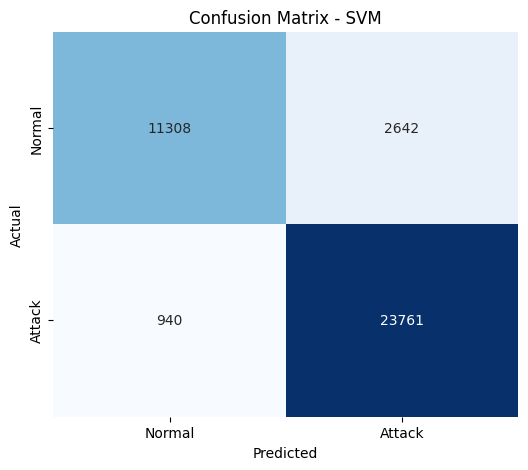

In [5]:
def evaluate_model(model, X_test, y_test):
    print("\n" + "=" * 60)
    print("       FINAL EVALUATION ON TEST SET (SVM)")
    print("=" * 60)

    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    # 1. Classification Report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=['Normal', 'Attack'], digits=4))

    # 2. Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Normal', 'Attack'],
                yticklabels=['Normal', 'Attack'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix - SVM')
    plt.show()

# Run Evaluation
evaluate_model(best_svm_model, X_test, y_test)